In [1]:
!pip install stable-baselines[mpi]==2.10.0
import gym
import numpy as np
import time
import os
from utils import *
import matplotlib.pyplot as plt

from stable_baselines.common.env_checker import check_env
from stable_baselines import DQN, PPO2, A2C, ACKTR, TRPO
from stable_baselines.bench import Monitor
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
%matplotlib inline

/home/cmb/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cmb/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cmb/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cmb/anaconda3/envs/thesis/lib/python3.6/site-pack

In [2]:
from ff_env_callback import FFEnv

# Instantiate the env
env_test = FFEnv()
env = FFEnv()

# Check the env
check_env(env_test, warn=True)

# Wrap it
env = Monitor(env, filename=None, allow_early_resets=True)

Episode 2	Average Score: 0.00

In [3]:
# Define the model
# Custom MLP Policy 
policy_kwargs = dict(net_arch=[256, 256])

model = TRPO('MlpPolicy', env, verbose=1)
#model = TRPO('MlpPolicy', env, n_steps = 256, policy_kwargs=policy_kwargs, verbose=1)

In [4]:
best_mean_reward = -np.inf
n_steps = 0

num_episodes = 5

def callback(_locals, _globals):
    """
    Callback is called at each step (timestep) for DQN
    :param_locals: (dict)
    :param_globals: (dict)
    """
    global n_steps, best_mean_reward
    
    if (env.episode) > num_episodes:
        return False
    
    # Returning false will stop training early
    return True

In [ ]:
# Train the agent
model.learn(total_timesteps=int(1e100), callback=callback)

********** Iteration 0 ************
Optimizing Policy...
sampling
Episode 2	Average Score: 0.00

In [6]:
model.save("trpo")

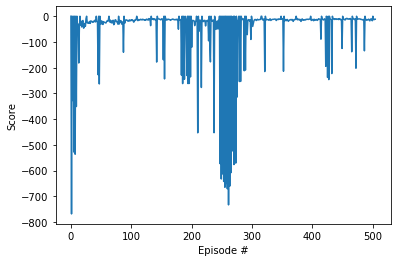

Text(0, 0.5, 'episode return')

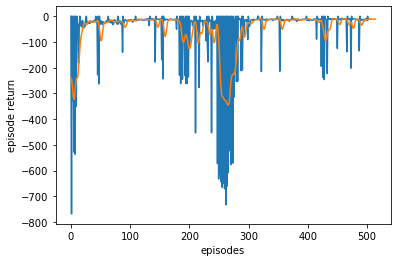

In [26]:
# Plotting the scores

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(env.scores)), env.scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Plotting 
Y = np.asarray(env.log.get_log('scores'))
Y2 = smooth(Y)
x = np.linspace(0, len(Y), len(Y))
fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, Y, Y2)
plt.xlabel('episodes')
plt.ylabel('episode return')

In [8]:
# model = DQN.load("dqn_")
model = PPO2.load("ppo2_")

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [30]:
# Evaluating the model
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render_()

Episode 509	Average Score: -25.51obj_center :  281.97903465113876 138.52970447450616 | goal :  {'x': 388, 'y': 228, 'w': 25}
tl : 87.65814237394507  | tr : 70.45217185463092  | dl : 44.205524 | dr : 30.822073
obj_center :  283.3602061066716 137.70299787337422 | goal :  {'x': 388, 'y': 228, 'w': 25}
tl : 87.08518512522937  | tr : 71.31110912389505  | dl : 44.205524 | dr : 38.208652
obj_center :  288.634956739965 154.33843363702124 | goal :  {'x': 388, 'y': 228, 'w': 25}
tl : 85.49911957730403  | tr : 70.73815187517935  | dl : 51.82722 | dr : 38.208652
obj_center :  290.1574954175426 154.72139429037952 | goal :  {'x': 388, 'y': 228, 'w': 25}
tl : 84.9718631243249  | tr : 70.16519462646367  | dl : 52.311134 | dr : 38.208652
obj_center :  291.68180200798014 155.09202701864524 | goal :  {'x': 388, 'y': 228, 'w': 25}
tl : 84.44916240752217  | tr : 69.59223737774798  | dl : 52.793217 | dr : 38.208652
obj_center :  293.20787022151194 155.45027085542188 | goal :  {'x': 388, 'y': 228, 'w': 25}
t

RuntimeError: Tried to step environment that needs reset

In [29]:
def evaluate(model, num_steps=1000):
  """
  Evaluate a RL agent
  :param model: (BaseRLModel object) the RL Agent
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episode_rewards = [0.0]
  obs = env_test.reset()
  for i in range(num_steps):
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)

      obs, reward, done, info = env_test.step(action)
      
      # Stats
      episode_rewards[-1] += reward
      if done:
          obs = env_test.reset()
          episode_rewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  
  return mean_100ep_reward

In [9]:
obs = env_test.reset()
for i in range(10):
  # _states are only useful when using LSTM policies
  action, _states = model.predict(obs)

  obs, reward, done, info = env_test.step(action)

In [10]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_steps=1000)

NameError: name 'evaluate' is not defined

In [10]:
model = DQN.load("dqn_")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [7]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Friction Finger Env")

LoadMonitorResultsError: no monitor files of the form *monitor.csv found in /tmp/gym/

In [ ]:
for i in range(5):
    print(env.step(np.random.randint(0,5,1)[0]))